In [76]:
from constant import *
import os
import caffe
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageColor
import copy
import IPython.display
import random


img_images = []
for class_id in range(100):
    for num in range(5):
        filename = '{}_{}.jpg'.format(class_id, num)
        img_temp = Image.open(imagenet_root + 'synthesized/' + filename)
        img = img_temp.copy()
        img_temp.close()
        img_images.append(img)
print "{} synthesized images loaded.".format(len(img_images))

500 synthesized images loaded.


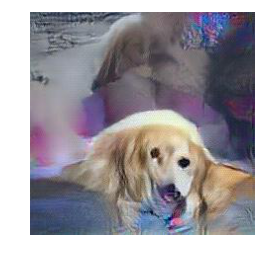

In [24]:
occ_img = img_images[random.randint(0, 500 - 1)]

plt.axis("off")
plt.imshow(np.asarray(occ_img))
plt.show()

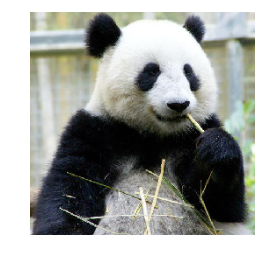

crop_0
0 0
41 -> 41


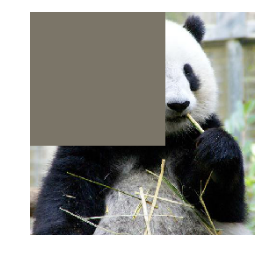

0 16
41 -> 41


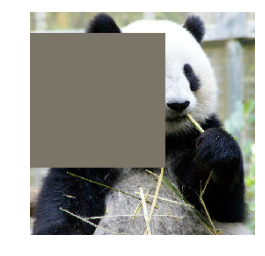

0 32
41 -> 41


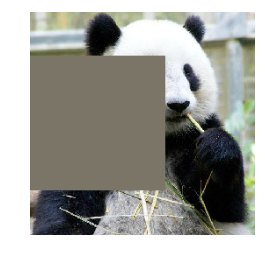

0 48
41 -> 41


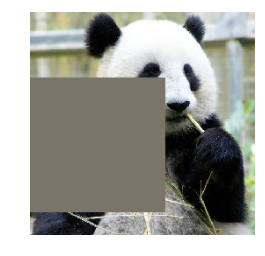

16 0
41 -> 41


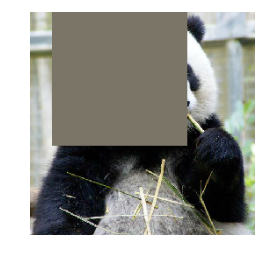

16 16
41 -> 41


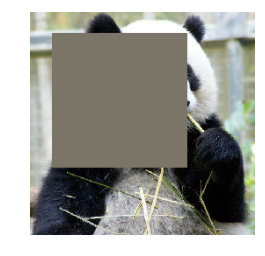

16 32
41 -> 41


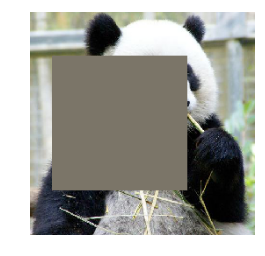

16 48
41 -> 41


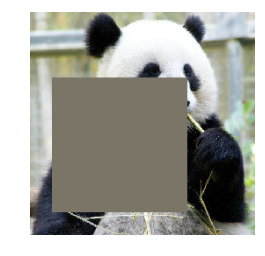

32 0
41 -> 17


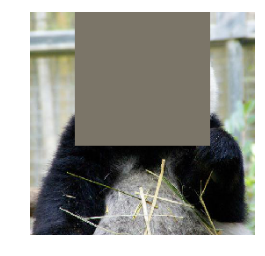

32 16
41 -> 41


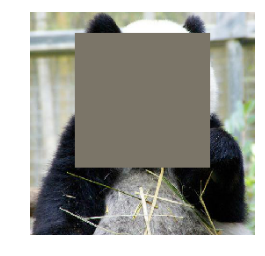

32 32
41 -> 41


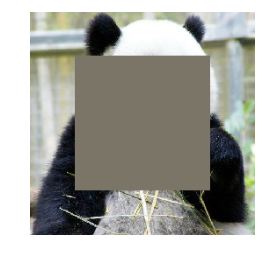

32 48
41 -> 41


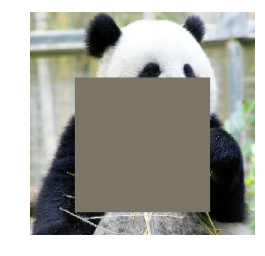

48 0
41 -> 64


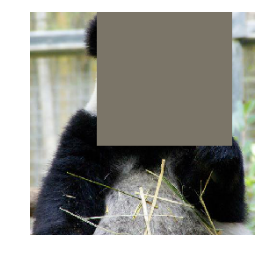

48 16
41 -> 64


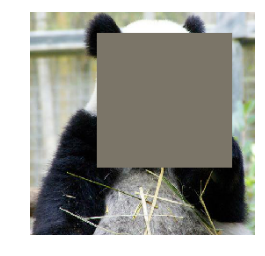

48 32
41 -> 41


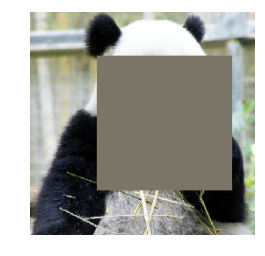

48 48
41 -> 41


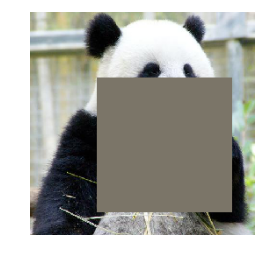

crop_all
0 0
41 -> 41


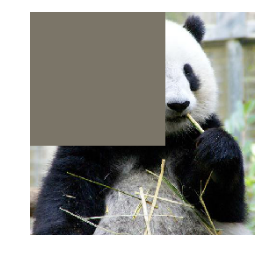

0 16
41 -> 41


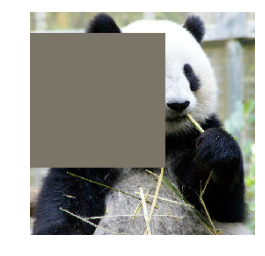

0 32
41 -> 41


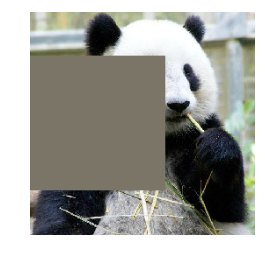

0 48
41 -> 41


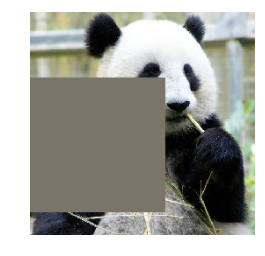

16 0
41 -> 41


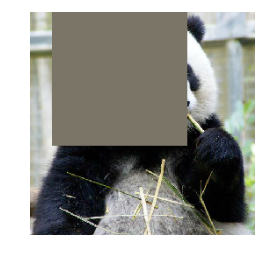

16 16
41 -> 41


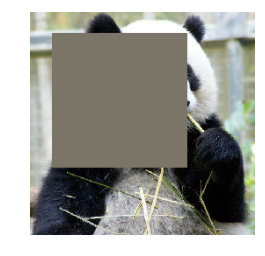

16 32
41 -> 41


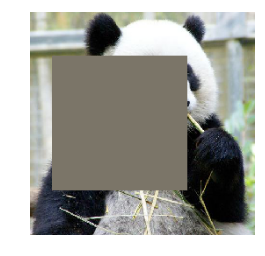

16 48
41 -> 41


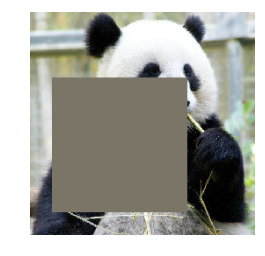

32 0
41 -> 41


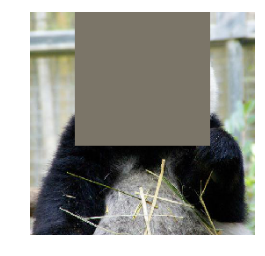

32 16
41 -> 41


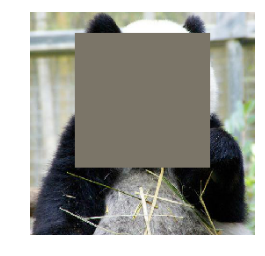

32 32
41 -> 41


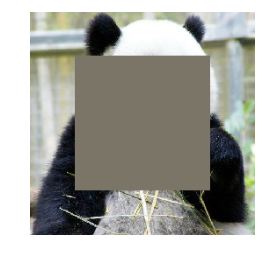

32 48
41 -> 41


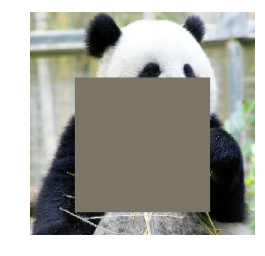

48 0
41 -> 41


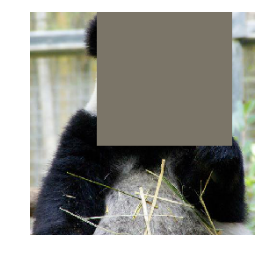

48 16
41 -> 41


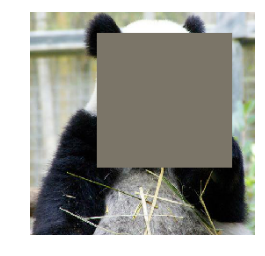

48 32
41 -> 41


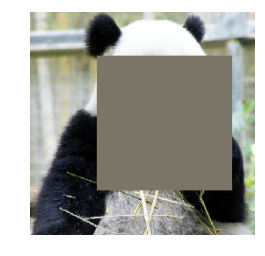

48 48
41 -> 41


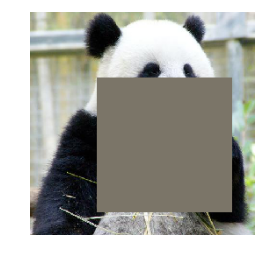

done


In [93]:
filename = '/home/haow3/software/interesting/deepdream/panda.jpg'
#filename = '/data2/haow3/data/imagenet/dataset/test_crop_0/n02510455_12024_crop_0_0_0.jpeg'
class_id = 41
models = ['crop_0', 'crop_all']

aperture_size = 0.6
step = 64

caffe.set_device(1)
caffe.set_mode_gpu()

nets = {}

for model in models:
    nets[model] = caffe.Net(result_root + 'model/finetune_alexnet_{}/deploy.prototxt'.format(model),
                    result_root + 'model/finetune_alexnet_{}/finetune_alexnet_{}.caffemodel'.format(model, model),
                    caffe.TEST)

transformer = caffe.io.Transformer({'data': nets[nets.keys()[0]].blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB


img = Image.open(filename)
img = img.resize((256, 256))    
plt.axis("off")
plt.imshow(np.asarray(img))
plt.show()

interval = 256 * (1 - aperture_size) / step
length = int(256 * aperture_size)
mean_color = (123, 117, 104)


heat_map = {}
for model in models:
    print model
    heat_map[model] = np.zeros((step, step))
    count = 0
    for i in range(step):
        for j in range(step):
            occluded_img = copy.copy(img)
            subrect = [0, 0, 0, 0]
            subrect[0] = interval * i
            subrect[1] = interval * j
            subrect[2] = subrect[0] + length
            subrect[3] = subrect[1] + length

            '''
            # Aperture
            d = ImageDraw.Draw(occluded_img)
            d.rectangle([0, 0, occluded_img.size[0], subrect[1]], fill=mean_color, outline=None)
            d.rectangle([0, 0, subrect[0], occluded_img.size[1]], fill=mean_color, outline=None)
            d.rectangle([subrect[2], 0, occluded_img.size[0], occluded_img.size[1]], fill=mean_color, outline=None)
            d.rectangle([0, subrect[3], occluded_img.size[0], occluded_img.size[1]], fill=mean_color, outline=None)
            '''
            
            # Sliding occluder
            d = ImageDraw.Draw(occluded_img)
            d.rectangle(subrect, fill=mean_color, outline=None)
            
            '''
            # Sliding ImageNet object occluder.
            occluded_img.paste(occ_img.resize((length, length)), (int(subrect[0]), int(subrect[1])))
            '''
            
            
            
            occluded_img.save(filename + 'temp.jpg')
            nets[model].blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(filename + 'temp.jpg'))
            nets[model].forward()
            
            '''
            # Top 1 or not.
            if nets[model].blobs['prob'].data[0].argmax() == class_id:
                heat_map[model][i][j] = 1
            else:
                heat_map[model][i][j] = 0
            '''
            
            '''
            # Rank.
            heat_map[model][i][j] = -1
            result = [(k, nets[model].blobs['prob'].data[0][k]) for k in range(len(nets[model].blobs['prob'].data[0]))]
            result = sorted(result, key = lambda k: k[1], reverse = True)
            #print result
            for k in range(100):
                if result[k][0] == class_id:
                    heat_map[model][i][j] = (k + 1) / 100.0
                    break
            '''
                    
            # Probability.
            heat_map[model][i][j] = nets[model].blobs['prob'].data[0][class_id]
            
            #os.remove(filename + 'temp.jpg')

            if (i % 16 == 0 and j % 16 == 0):
                print i, j
                print '{} -> {}'.format(class_id, nets[model].blobs['prob'].data[0].argmax())
                plt.axis("off")
                plt.imshow(np.asarray(occluded_img))
                plt.show()

print 'done'

[[ 0.99955755  0.99949908  0.99939203 ...,  0.99998903  0.99999118
   0.9999913 ]
 [ 0.99963534  0.99964809  0.99959248 ...,  0.99999166  0.99999356
   0.99999487]
 [ 0.99899405  0.99914467  0.99918073 ...,  0.99998963  0.99999261
   0.99999452]
 ..., 
 [ 0.83180296  0.79103619  0.7134431  ...,  0.99988163  0.99993658
   0.99994957]
 [ 0.87719452  0.832358    0.78674388 ...,  0.99992883  0.9999584
   0.99996281]
 [ 0.91027409  0.87930447  0.86241454 ...,  0.99991524  0.99994695
   0.99995339]]
[[ 0.99877602  0.99895322  0.99890089 ...,  0.99997616  0.99997663
   0.99997747]
 [ 0.99885058  0.99903834  0.99906534 ...,  0.99997568  0.99997866
   0.99998295]
 [ 0.99741733  0.99798858  0.99827421 ...,  0.99998105  0.99998105
   0.99998546]
 ..., 
 [ 0.95265758  0.94495791  0.93326122 ...,  0.99966419  0.99973577
   0.99977905]
 [ 0.97050112  0.96510714  0.96009409 ...,  0.99981028  0.99983108
   0.99984753]
 [ 0.97978526  0.97766203  0.97690785 ...,  0.99976975  0.99979967
   0.9998067 ]]
c

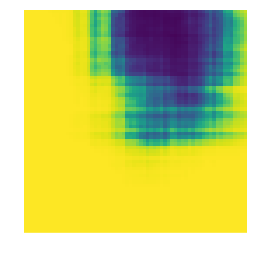

crop_all


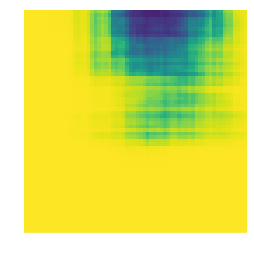

In [94]:
print heat_map['crop_0']
print heat_map['crop_all']

for model in models:
    print model  
    plt.axis("off")
    plt.imshow(np.swapaxes(heat_map[model],0,1) , cmap='viridis', interpolation='none', vmin=0, vmax=1)
    #plt.colorbar()
    plt.show()

In [ ]:
for model in models:
    plt.pcolor(x, y, z, cmap='hot', vmin=0, vmax=1)
    plt.colorbar()